# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Exploratory-analysis" data-toc-modified-id="Exploratory-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory analysis</a></div><div class="lev2 toc-item"><a href="#Find-data-overlap" data-toc-modified-id="Find-data-overlap-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find data overlap</a></div><div class="lev2 toc-item"><a href="#Pruned-range" data-toc-modified-id="Pruned-range-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Pruned range</a></div><div class="lev2 toc-item"><a href="#Summary-statistics-of-NSRDB-vs-ground-based-measurements" data-toc-modified-id="Summary-statistics-of-NSRDB-vs-ground-based-measurements-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Summary statistics of NSRDB vs ground based measurements</a></div><div class="lev2 toc-item"><a href="#Clear-sky-periods" data-toc-modified-id="Clear-sky-periods-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Clear sky periods</a></div><div class="lev2 toc-item"><a href="#Summary-statistics-for-clear-and-cloudy-periods" data-toc-modified-id="Summary-statistics-for-clear-and-cloudy-periods-35"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Summary statistics for clear and cloudy periods</a></div>

# Introduction

This notebook will explore how closely NSRDB satellite data and RTC ground data agree on irradiance measurements.  We will also look at the agreement between modeled irradiance from NSRDB and that supplied by PVLIB.  Ideally we hope to see that measured irradiances and modeled irradiances are close to one another for both collection methods.

# Load data

In [17]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pytz
import itertools

import pvlib
import utils

import concurrent.futures

np.set_printoptions(precision=4)
%matplotlib notebook

In [18]:
NSRDB_PATH = os.path.expanduser('~/data_sets/nsrdb/abq_area/')
GROUND_PATH = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')

In [19]:
nsrdb_df = utils.read_dir_nsrdb(NSRDB_PATH, 'US/Mountain')
ground_df = utils.read_snl_rtc(GROUND_PATH, 'Etc/GMT+7', 'US/Mountain')

In [20]:
# rename so GHI is named same as NSRDB
ground_df['GHI'] = ground_df['Global_Wm2']

In [21]:
# filter off below zero irradiance
nsrdb_df[nsrdb_df['GHI'] < 0] = 0
ground_df[ground_df['GHI'] < 0] = 0

# Exploratory analysis

In [22]:
def mean_abs_diff(this, that):
    return np.mean(np.abs((this - that)))

## Find data overlap

In [23]:
intersection = nsrdb_df.index.intersection(ground_df.index)
EARLIEST_IDX = intersection[0]
LATEST_IDX = intersection[-1]
print('NSRDB date range: {} -> {}'.format(nsrdb_df.index[0], nsrdb_df.index[-1]))
print('Ground date range: {} -> {}'.format(ground_df.index[0], ground_df.index[-1]))
print('Earliest intersection: {}, latest intersection: {}'.format(EARLIEST_IDX, LATEST_IDX))

NSRDB date range: 1997-12-31 17:00:00-07:00 -> 2015-12-31 16:30:00-07:00
Ground date range: 2015-01-08 22:31:00-07:00 -> 2017-04-06 01:00:00-06:00
Earliest intersection: 2015-01-08 23:00:00-07:00, latest intersection: 2015-12-31 16:30:00-07:00


Not very much overlap - only about a year.

<IPython.core.display.Javascript object>


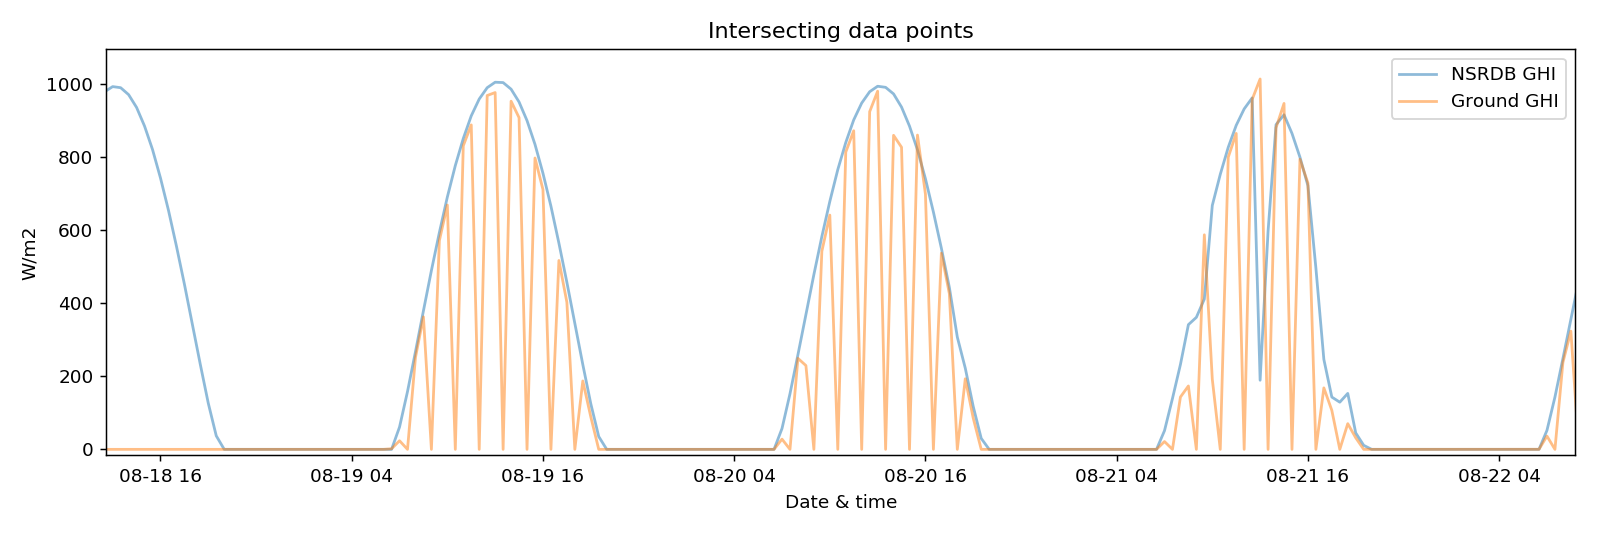

In [24]:
fig, ax = plt.subplots(figsize=(12,4))

p1 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['GHI'], 
             alpha=.5, label='NSRDB GHI')

p2 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['GHI'], 
             alpha=.5, label='Ground GHI')

_ = ax.set_title('Intersecting data points')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')

_ = ax.legend()

_ = fig.tight_layout()

Even less overlap than initially thought.  We will set earliest date to be Oct 1, 2015.  Earlier overlap (starting in Aug) has issues with the data/collection.  Values drop to zero every so often.

In [25]:
intersection = intersection[intersection >= '10-01-2015']

## Pruned range

In [26]:
# generate clearsky model for ground-based measurements
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 'lat': 35.0549, 'lon': -106.5433}
rtc = utils.make_pvlib_sys(**snl_params)
clear_skies = rtc.get_clearsky(ground_df.loc[intersection].index)
clear_skies = pd.Series(clear_skies['ghi'])
clear_skies.index = intersection
ground_df['Clearsky GHI'] = clear_skies

<IPython.core.display.Javascript object>


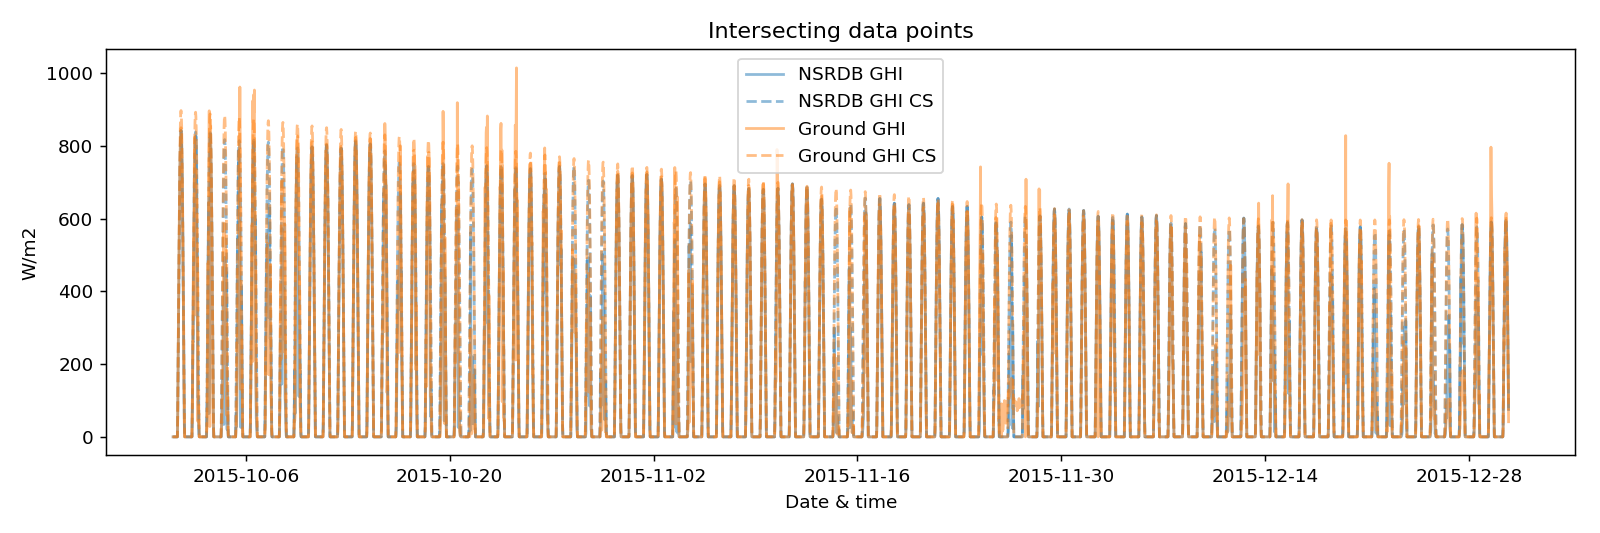

In [27]:
fig, ax = plt.subplots(figsize=(12,4))

p1 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['GHI'], 
             alpha=.5, label='NSRDB GHI')
p2 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['Clearsky GHI'], 
             alpha=.5, label='NSRDB GHI CS', color=p1[0].get_color(), linestyle='--')

p3 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['GHI'], 
             alpha=.5, label='Ground GHI')
p4 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['Clearsky GHI'], 
             alpha=.5, label='Ground GHI CS', color=p3[0].get_color(), linestyle='--')

_ = ax.set_title('Intersecting data points')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')

_ = ax.legend()

_ = fig.tight_layout()

Visually, the a greement looks pretty good.  Some issues with ground measurements in late November, but otherwise things look to match pretty well.  The modeled irradiances also lines up well.

## Summary statistics of NSRDB vs ground based measurements

In [28]:
val = mean_abs_diff(nsrdb_df.loc[intersection]['GHI'], ground_df.loc[intersection]['GHI'])
print('Mean absolute difference of measured GHI: ', val)
val = mean_abs_diff(nsrdb_df.loc[intersection]['Clearsky GHI'], ground_df.loc[intersection]['Clearsky GHI'])
print('Mean absolute difference of modeled GHI: ', val)

Mean absolute difference of measured GHI:  25.4612898366
Mean absolute difference of modeled GHI:  8.9544063918


The average difference between the measured GHI is relatively small at 25W/m2.  For the modeled values, it's much lower at 8.95W/m2.  It would've been ideal if the two measurements were off by the same amount, but we will see how this affects detection.

## Clear sky periods

In [29]:
nsrdb_df['sky_status'] = (nsrdb_df['Cloud Type'] == 0) & (nsrdb_df['GHI'] > 0)

<IPython.core.display.Javascript object>


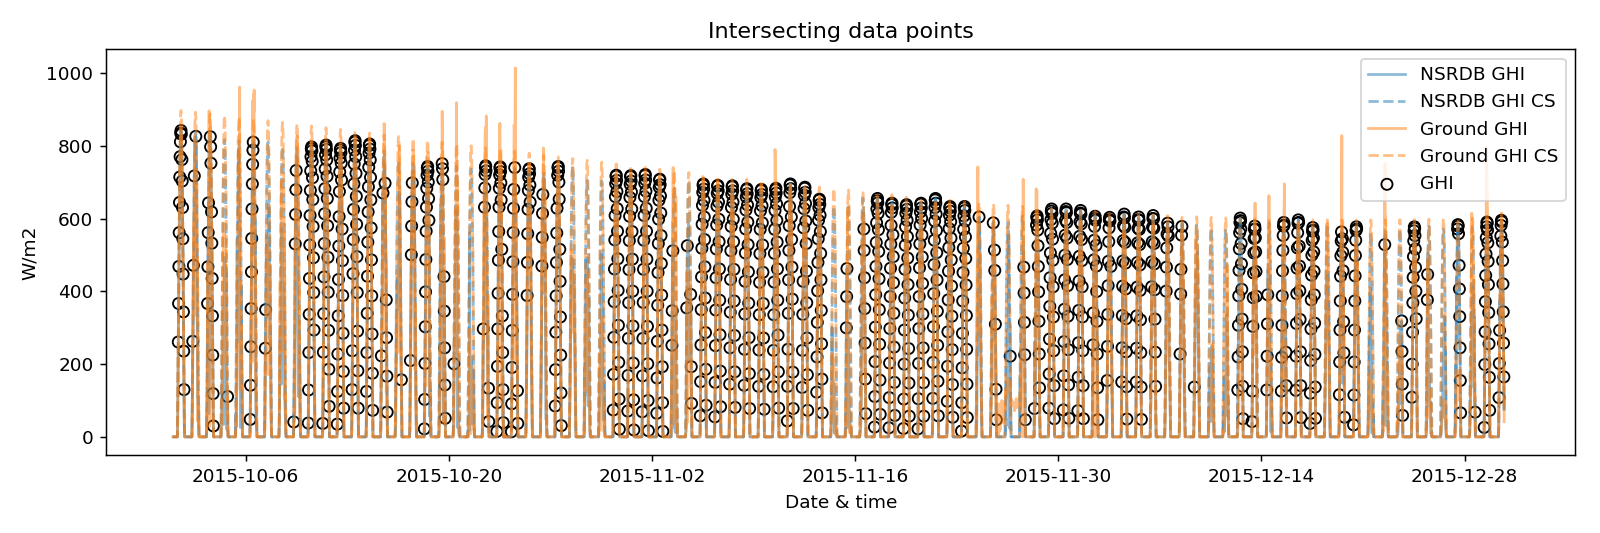

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [30]:
fig, ax = plt.subplots(figsize=(12,4))

p1 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['GHI'], 
             alpha=.5, label='NSRDB GHI')
p2 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['Clearsky GHI'], 
             alpha=.5, label='NSRDB GHI CS', color=p1[0].get_color(), linestyle='--')

p3 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['GHI'], 
             alpha=.5, label='Ground GHI')
p4 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['Clearsky GHI'], 
             alpha=.5, label='Ground GHI CS', color=p3[0].get_color(), linestyle='--')

p5 = ax.scatter(nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1].index,
                nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1]['GHI'],
                marker='o', edgecolor='black', facecolor='none')

_ = ax.set_title('Intersecting data points')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')

_ = ax.legend()

_ = fig.tight_layout()

From an 'eye test', the marked clearsky periods by NSRDB seem to match intuition from ground based measurements.  

## Summary statistics for clear and cloudy periods

In [31]:
clear_mask = nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1].index
cloudy_mask = nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 0].index

# MAD between NSRDB and RTC values during clear periods (from NSRDB)
nsrdb_ghi_clear = nsrdb_df.loc[intersection].loc[clear_mask]['GHI']
ground_ghi_clear = ground_df.loc[intersection].loc[clear_mask]['GHI']
print('Clear period mean abs diff between NSRDB, RTC: ', mean_abs_diff(nsrdb_ghi_clear, ground_ghi_clear))

# MAD between NSRDB and RTC values during cloudy periods (from NSRDB)
nsrdb_ghi_cloudy = nsrdb_df.loc[intersection].loc[cloudy_mask]['GHI']
ground_ghi_cloudy = ground_df.loc[intersection].loc[cloudy_mask]['GHI']
print('Cloudy period mean_abs_diff between NSRDB, RTC: ', mean_abs_diff(nsrdb_ghi_cloudy, ground_ghi_cloudy))

# Ratio of measured to modeled irradiance (NSRDB) during clear periods (from NSRDB)
nsrdb_ghi_model_clear = nsrdb_df.loc[intersection].loc[clear_mask]['Clearsky GHI']
ground_ghi_model_clear = ground_df.loc[intersection].loc[clear_mask]['Clearsky GHI']

nsrdb_ghi_model_cloudy = nsrdb_df.loc[intersection].loc[cloudy_mask]['Clearsky GHI']
ground_ghi_model_cloudy = ground_df.loc[intersection].loc[cloudy_mask]['Clearsky GHI']

print('---' * 20)

print('Clear period GHI:Clearsky GHI ratio - NSRDB: ', 
      np.mean(nsrdb_ghi_clear / nsrdb_ghi_model_clear), ' +/- ',
      np.std(nsrdb_ghi_clear / nsrdb_ghi_model_clear))

print('Clear period GHI:Clearsky GHI ratio - ground: ', 
      np.mean(ground_ghi_clear / ground_ghi_model_clear), ' +/- ',
      np.std(ground_ghi_clear / ground_ghi_model_clear))

print('Cloudy period GHI:Clearsky GHI ratio - NSRDB: ', 
      np.mean(nsrdb_ghi_cloudy / nsrdb_ghi_model_cloudy), ' +/- ',
      np.std(nsrdb_ghi_cloudy / nsrdb_ghi_model_cloudy))

print('Cloudy period GHI:Clearsky GHI ratio - ground: ', 
      np.mean((ground_ghi_cloudy / ground_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0)), ' +/- ',
      np.std((ground_ghi_cloudy / ground_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0)))

print('---' * 20)

print('Clear period mean abs ratio diff from 1 - NSRDB: ', 
      np.mean(np.abs(1 - nsrdb_ghi_clear / nsrdb_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0)), ' +/- ',
      np.std(np.abs(1 - nsrdb_ghi_clear / nsrdb_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0)))

print('Clear period mean abs ratio diff from 1 - ground: ', 
      np.mean(np.abs(1 - (ground_ghi_clear / ground_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0))), ' +/- ',
      np.std(np.abs(1 - (ground_ghi_clear / ground_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0))))

print('Cloudy period mean abs ratio diff from 1 - NSRDB: ', 
      np.mean(np.abs(1 - nsrdb_ghi_cloudy / nsrdb_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0)), ' +/- ',
      np.std(np.abs(1 - nsrdb_ghi_cloudy / nsrdb_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0)))

print('cloudy period mean abs ratio diff from 1 - ground: ', 
      np.mean(np.abs(1 - (ground_ghi_cloudy / ground_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0))), ' +/- ',
      np.std(np.abs(1 - (ground_ghi_cloudy / ground_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0))))

Clear period mean abs diff between NSRDB, RTC:  29.2050053759
Cloudy period mean_abs_diff between NSRDB, RTC:  24.3227657445
------------------------------------------------------------
Clear period GHI:Clearsky GHI ratio - NSRDB:  1.0  +/-  0.0
Clear period GHI:Clearsky GHI ratio - ground:  0.918165661076  +/-  0.180995394548
Cloudy period GHI:Clearsky GHI ratio - NSRDB:  0.577198191493  +/-  0.300429001086
Cloudy period GHI:Clearsky GHI ratio - ground:  0.13481132839  +/-  0.299290733748
------------------------------------------------------------
Clear period mean abs ratio diff from 1 - NSRDB:  0.0  +/-  0.0
Clear period mean abs ratio diff from 1 - ground:  0.0951511278001  +/-  0.174362997087
Cloudy period mean abs ratio diff from 1 - NSRDB:  0.105543951605  +/-  0.236676224263
cloudy period mean abs ratio diff from 1 - ground:  0.876472969196  +/-  0.264426766909


/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Clear and cloudy periods are off by similar amounts (29 vs 24 W/m2).  Interestingly though, the GHI:GHI_cs ratio for NSRDB is exactly 1 for clear periods (with no variance).  This is not so with ground based measurements where the ratio drops to about .9 with standard deviation of .18.  Cloudy period ratios are about .6 (+/- .3) for NSRDB and lower still for ground measurements at .13 (+/- .3).